In [13]:
# Clear workspace
%reset
import sys
sys.path.append("/Users/jason.wang/Desktop/hif2gene/scripts/helper_functions/") # replace path

# custom modules
import cluster_features_combine_p_values as cf
import hypothesis_testing as ht

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
from scipy.stats import sem, percentileofscore
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

base_dir = "~/Desktop/hif2gene"
model_output_dir = "/Users/jason.wang/Desktop/hif2gene/data/model_outputs/pd1_pdl1_ctla4" # change path


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [14]:
seed = 360
np.random.seed(seed)
outcome = 'CTLA4'

In [15]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/pancancer.hif.clusters.csv".format(base_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
clusters

Number of Clusters: 20


,Unnamed: 0,x
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,1
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,2
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,3
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,1
...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,1
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,1
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,9
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,9


## Load in Null Distributions

AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0506557669659983e-06, 5.376627833527343e-05, 0.00010992467501054933, 0.0002075906605050273, 0.00024199872925273608, 0.0003223532535180233, 0.00032356407232053864, 0.0004198204274971587, 0.00042271672416040895, 

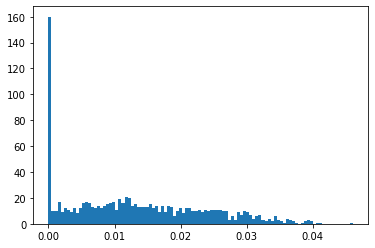

7.5
100.0


In [16]:
hif_null_distributions = pkl.load(open("{0}/hif_beta_null_distributions/{1}_hif_beta_null_distributions.pkl".format(model_output_dir, outcome), "rb"))
for k, v in hif_null_distributions.items():
    print(k)
    print(sorted(v))
    plt.hist(v, bins=100)
    plt.show()
    print(percentileofscore(v, 0))
    print(percentileofscore(v, 0.1))
    break

## Load in HIF Betas

In [17]:
betas_df = pd.read_csv("{0}/coefficients/pancancer/{1}_model_ensemble.csv".format(model_output_dir, outcome))
betas_df = betas_df[['HIF', 'Beta', 'Cluster']]

# Remove zeros
betas_df = betas_df[betas_df['Beta'] != 0.0]
betas_df


,HIF,Beta,Cluster
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,0.015348,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,0.023364,1
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,0.023722,3
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,0.024322,1
8,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF CANCER IN EPITHELIAL_HE,-0.000664,6
...,...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,0.001600,1
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,0.016574,1
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,0.022080,9
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,0.017381,9


## Compute P-Values

In [18]:
# One-sided
p_values = []
for index, row in betas_df.iterrows():
    hif = row['HIF']
    beta = row['Beta']
    null_distribution = hif_null_distributions[hif]
    
    if (beta > 0):
        percentile = percentileofscore(null_distribution, beta)
        if (percentile == 100.0):
            percentile -= 0.1 # precision to 1/10th of a percentage point
        p_value = (100.0 - percentile)/100.0
        p_values.append(p_value)
    elif (beta < 0):
        percentile = percentileofscore(null_distribution, beta)
        if (percentile == 0.0):
            percentile += 0.1
        p_value = percentile/100.0
        p_values.append(p_value)
    
    print(beta, p_value)

0.015347692368106585 0.395
0.023364123709893426 0.29599999999999993
0.023722126744362384 0.345
0.024322442575551464 0.401
-0.0006644398054719173 0.002
-0.0003947086818476733 0.002
0.00010064351532158628 0.20099999999999996
-0.008614719254326072 0.001
-0.006396807302283781 0.001
-0.0008345155476875651 0.001
0.01097118694830746 0.24099999999999994
0.014389325458185718 0.34
0.011691128397955287 0.58
0.02128456545622361 0.526
0.0016933057752871274 0.812
0.0207005097987103 0.586
0.020609502467334062 0.677
0.02150922245675146 0.6759999999999999
0.007017339642074614 0.308
-0.008492607080111602 0.001
-0.005729842847251897 0.001
-0.00035875950656036836 0.001
-0.01049091006386528 0.001
0.0098827307704512 0.5479999999999999
0.01277693588661695 0.41100000000000003
0.006690737120071596 0.546
0.039753841080067534 0.05900000000000006
0.014609983449795616 0.5489999999999999
0.0015738935541084913 0.835
0.013744678083615557 0.648
0.01752098946550093 0.488
0.009750063436607809 0.752
0.010995772184611022 

In [19]:
betas_df['P-Value'] = p_values
betas_df

,HIF,Beta,Cluster,P-Value
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,0.015348,1,0.395
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,0.023364,1,0.296
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,0.023722,3,0.345
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,0.024322,1,0.401
8,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF CANCER IN EPITHELIAL_HE,-0.000664,6,0.002
...,...,...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,0.001600,1,0.903
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,0.016574,1,0.436
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,0.022080,9,0.606
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,0.017381,9,0.775


## Empirical Brown's Method

In [20]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/PanImmune/datasets/pancancer.{1}.joined.USE.csv".format(base_dir, outcome))
df = df.iloc[:,1:]

# Normalize HIFs and define X, y
X = df.iloc[:,:607]
X_normalized = (X-X.mean())/X.std()
X_normalized

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..STROMA._HE,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE
0,0.625780,1.320111,-0.454536,1.650450,1.312188,-0.561140,0.228032,0.561140,0.416323,0.409658,...,0.657724,0.641397,-0.049494,0.703656,0.552410,0.468279,1.811266,0.511670,0.058301,0.269384
1,0.890326,2.099043,-0.378713,2.197757,1.778738,-0.609883,0.646773,0.609883,0.261875,0.385380,...,-0.167697,-0.225805,-0.227107,0.097471,0.082867,0.014095,-0.380200,-0.440251,-0.433379,-0.455277
2,-0.496558,-0.192178,-0.334060,-0.182341,-0.380414,-0.517463,0.686040,0.517463,-0.660456,0.236147,...,-0.347063,-0.411710,-0.397972,-0.323583,-0.324492,-0.384225,-0.494736,-0.497219,-0.479853,-0.512822
3,-0.090602,0.965621,-0.475329,1.079162,0.582686,-0.928909,0.935311,0.928909,0.947043,1.131682,...,-0.408067,-0.417929,-0.357829,-0.455519,-0.418541,-0.455844,-0.282874,-0.500636,-0.532608,-0.537716
4,-1.150850,-1.194802,-0.432223,-1.032426,-1.239142,-2.231844,-1.898384,2.231844,-2.300306,-2.919595,...,-0.603285,-0.660853,-0.523090,-0.695349,-0.602679,-0.658396,-0.599519,-0.591152,-0.566951,-0.607675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,0.148690,0.717826,1.227934,3.232446,1.976733,-1.432699,-1.248386,1.432699,-1.086134,-0.184441,...,2.308081,2.041564,-0.284405,1.195156,2.258601,1.893650,-0.368536,0.582470,1.573201,1.445904
1617,0.420710,0.146911,0.270728,-0.335945,0.034820,0.911593,0.379987,-0.911593,0.504437,0.636137,...,-0.068714,-0.156438,-0.474712,-0.579942,-0.539856,-0.591336,-0.535463,-0.007758,0.059233,-0.007239
1618,0.780195,0.877285,2.379506,1.013846,1.024075,-0.101601,-0.048766,0.101601,-0.056752,-0.549848,...,0.241515,0.239594,-0.348908,-0.250492,-0.275670,-0.329180,0.203757,0.507637,0.866417,0.844406
1619,-0.178664,0.051085,3.003612,-0.068767,-0.138728,-0.124584,0.631810,0.124584,-0.272335,-0.483505,...,-0.022396,-0.101614,-0.159172,0.210112,0.071786,0.021813,-0.209832,0.571274,0.540835,0.487242


In [21]:
# Filter dataset to only include HIFs associated with non-zero betas
X_normalized_filterd = X_normalized.iloc[:, list(betas_df.index)]
X_normalized_filterd.columns = betas_df['HIF']
X_normalized_filterd

HIF,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF CANCER IN EPITHELIAL_HE,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF CANCER IN ESI_0080_HE,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF CANCER IN STROMA_HE,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF FIBROBLAST IN EPITHELIAL_HE,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF FIBROBLAST IN ESI_0080_HE,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF FIBROBLAST IN TUMOR_HE,...,TOTAL [LYMPHOCYTE CELLS] IN [ESI_0080]_HE,TOTAL [LYMPHOCYTE CELLS] IN [STROMA]_HE,TOTAL [LYMPHOCYTE CELLS] IN [TUMOR]_HE,TOTAL [MACROPHAGE CELLS] IN [ESI_0080]_HE,TOTAL [MACROPHAGE CELLS] IN [STROMA]_HE,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,TOTAL [PLASMA CELLS] IN [STROMA]_HE,TOTAL [PLASMA CELLS] IN [TUMOR]_HE
0,0.625780,1.320111,1.650450,1.312188,0.416323,0.409658,0.849043,-0.679332,0.302952,0.674237,...,0.948187,0.657724,0.641397,0.703656,0.552410,0.468279,1.811266,0.511670,0.058301,0.269384
1,0.890326,2.099043,2.197757,1.778738,0.261875,0.385380,0.787298,-1.019954,0.275565,0.260228,...,-0.140524,-0.167697,-0.225805,0.097471,0.082867,0.014095,-0.380200,-0.440251,-0.433379,-0.455277
2,-0.496558,-0.192178,-0.182341,-0.380414,-0.660456,0.236147,0.194189,-0.415607,0.504865,-0.173390,...,-0.377501,-0.347063,-0.411710,-0.323583,-0.324492,-0.384225,-0.494736,-0.497219,-0.479853,-0.512822
3,-0.090602,0.965621,1.079162,0.582686,0.947043,1.131682,1.670292,1.133000,1.008632,1.526901,...,-0.354295,-0.408067,-0.417929,-0.455519,-0.418541,-0.455844,-0.282874,-0.500636,-0.532608,-0.537716
4,-1.150850,-1.194802,-1.032426,-1.239142,-2.300306,-2.919595,0.007419,-1.742951,-1.495206,-1.981052,...,-0.742545,-0.603285,-0.660853,-0.695349,-0.602679,-0.658396,-0.599519,-0.591152,-0.566951,-0.607675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,0.148690,0.717826,3.232446,1.976733,-1.086134,-0.184441,-0.040416,-0.022822,0.495020,0.918516,...,0.902440,2.308081,2.041564,1.195156,2.258601,1.893650,-0.368536,0.582470,1.573201,1.445904
1617,0.420710,0.146911,-0.335945,0.034820,0.504437,0.636137,-0.198491,0.644309,0.339341,-0.202767,...,-0.344700,-0.068714,-0.156438,-0.579942,-0.539856,-0.591336,-0.535463,-0.007758,0.059233,-0.007239
1618,0.780195,0.877285,1.013846,1.024075,-0.056752,-0.549848,0.141618,-0.033528,-0.192719,0.212270,...,0.184544,0.241515,0.239594,-0.250492,-0.275670,-0.329180,0.203757,0.507637,0.866417,0.844406
1619,-0.178664,0.051085,-0.068767,-0.138728,-0.272335,-0.483505,-0.198066,-0.178228,-0.023248,-0.779543,...,-0.063607,-0.022396,-0.101614,0.210112,0.071786,0.021813,-0.209832,0.571274,0.540835,0.487242


In [22]:
# HIFs are highly-correlated; thus P-values are correlated / dependent
# Apply the Empirical Brown's Method to combine P-values per HIF cluster
combined_pvals = cf.combine_p_values(np.array(betas_df['Cluster']), betas_df.set_index('HIF'), 
                                     X_normalized_filterd, p_val_col='P-Value')
combined_pvals

array([4.44194399e-02, 2.44882258e-05, 1.43679889e-04, 6.68392421e-07,
       4.99148668e-05, 1.97439576e-12, 1.98811997e-01, 5.18480966e-03,
       4.87449535e-01, 1.91712645e-04, 8.45512338e-08, 2.07490690e-04,
       2.63761737e-11, 4.01036577e-05, 2.92825241e-21, 3.81904568e-07,
       1.99099674e-07, 1.41261060e-05])

In [23]:
len(combined_pvals)

18

In [24]:
significant, ebm_q_values = ht.bh_correction(combined_pvals, alpha=0.05) # Q-values = corrected P-values

In [25]:
combined_corrected_pvals = pd.DataFrame({
    "Cluster Group": sorted(list(set(betas_df['Cluster']))),
    "Combined P-Value": combined_pvals,
    "Q-Value": ebm_q_values # Corrected + Combined P-Value)
})
combined_corrected_pvals

,Cluster Group,Combined P-Value,Q-Value
0,1,4.441944e-02,4.997187e-02
1,2,2.448823e-05,4.897645e-05
2,3,1.436799e-04,2.155198e-04
3,4,6.683924e-07,1.718723e-06
4,5,4.991487e-05,8.167887e-05
5,6,1.974396e-12,1.776956e-11
6,7,1.988120e-01,2.105068e-01
7,8,5.184810e-03,6.221772e-03
8,9,4.874495e-01,4.874495e-01
9,10,1.917126e-04,2.654483e-04
